<a href="https://colab.research.google.com/github/gmshroff/metaLearning2022/blob/main/code/nb3_MAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# METRIC-BASED META-LEARNING using Matching Networks

In [ ]:
# !pip install import_ipynb --quiet

In [ ]:
# !pip install learn2learn --quiet

In [ ]:
# import requests

In [ ]:
# r=requests.get("https://github.com/gmshroff/metaLearning2022/blob/main/code/utils.ipynb?raw=true")
# with open('./utils.ipynb','wb') as f: f.write(r.content)

In [ ]:
# r=requests.get("https://github.com/gmshroff/metaLearning2022/blob/main/code/l2lutils.ipynb?raw=true")
# with open('./l2lutils.ipynb','wb') as f: f.write(r.content)

In [6]:
import import_ipynb
import utils

importing Jupyter notebook from utils.ipynb


In [7]:
from IPython import display
import torch
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from l2lutils import KShotLoader
from IPython import display

importing Jupyter notebook from l2lutils.ipynb


In [8]:
import models

importing Jupyter notebook from models.ipynb


# Data Generation and Loading

In [9]:
#Generate data - euclidean
meta_train_ds, meta_test_ds, full_loader = utils.euclideanDataset(n_samples=10000,n_features=20,n_classes=10,batch_size=32)

In [5]:
# Define an MLP network. Note that input dimension has to be data dimension. For classification
# final dimension has to be number of classes; for regression one.
#torch.manual_seed(10)
net = models.MLP(dims=[20,32,32,10])

In [6]:
# Train the network; note that network is trained in place so repeated calls further train it.
net,loss,accs=models.Train(net,full_loader,lr=1e-2,epochs=50,verbose=True)

Epoch   49 Loss: 4.59505e-02 Accuracy: 0.99255


In [7]:
#Training accuracy.
models.accuracy(net,meta_train_ds.samples,meta_train_ds.labels,verbose=True)

7448.0 7500


0.9930666666666667

In [8]:
# Test accuracy.
models.accuracy(net,meta_test_ds.samples,meta_test_ds.labels)

2425.0 2500


0.97

# Meta-Learning: Tasks

Generate a k-shot n-way loader using the meta-training dataset

In [ ]:
meta_train_kloader=KShotLoader(meta_train_ds,shots=5,ways=5)

Sample a task - each task has a k-shot n-way training set and a similar test set

In [6]:
d_train,d_test=meta_train_kloader.get_task()

Let's try directly learning using the task training set albeit its small size: create a dataset and loader and train it with the earlier network and Train function.

In [7]:
taskds = utils.MyDS(d_train[0],d_train[1])

In [8]:
d_train_loader = torch.utils.data.DataLoader(dataset=taskds,batch_size=1,shuffle=True)

In [ ]:
net,loss,accs=models.Train(net,d_train_loader,lr=1e-1,epochs=10,verbose=False)

How does it do on the test set of the sampled task?

In [14]:
models.accuracy(net,d_test[0],d_test[1])

24.0 25


0.96

# Matching Networks

In [10]:
import learn2learn as l2l
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

Sampling a training task: Note that each of d_train and d_test is a tuple comprising of a training set, and labels.

In [ ]:
meta_train_kloader=KShotLoader(meta_train_ds,shots=5,ways=5)

In [83]:
d_train,d_test=meta_train_kloader.get_task()

In [84]:
lossfn = torch.nn.NLLLoss()

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')
# %ls drive/MyDrive/'Colab Notebooks'

In [15]:
# !cp drive/MyDrive/'Colab Notebooks'/models.ipynb .
# !cp drive/MyDrive/'Colab Notebooks'/MAN.ipynb .

In [85]:
import models

This will be the class implementing Matching networks that you need to write for hw3

In [86]:
import MAN
import importlib
importlib.reload(MAN)

from MAN import MAN

In [18]:
X = torch.Tensor([[1,1,1],[-1,-1,-1],[1,2,3],[-1,-2,-3]])
y_tr = torch.LongTensor([0,1])
x_tr = X[[0,1],:]
d_tr = (x_tr, y_tr)

In [87]:
import MAN
import importlib
importlib.reload(MAN)

from MAN import MAN
man = MAN(dims=[3,8,8])

In [30]:
man(X, d_tr)

batch size: 4 support set size:  2
test sample torch.Size([2, 8])
support set sample torch.Size([2, 8])
test sample torch.Size([2, 8])
support set sample torch.Size([2, 8])
test sample torch.Size([2, 8])
support set sample torch.Size([2, 8])
test sample torch.Size([2, 8])
support set sample torch.Size([2, 8])
torch.Size([4, 2])


tensor([[0.7226, 0.2774],
        [0.2774, 0.7226],
        [0.7668, 0.2332],
        [0.2508, 0.7492]], grad_fn=<StackBackward0>)

# Putting it all together: Training a Matching Network
Now let's put all of the above in a loop - training Matching Network algorithm:

In [11]:
# Redifning accuracy function so that it takes h - dataset context - as input since net requires it.
def accuracy(Net,X_test,y_test,h,verbose=True):
    #Net.eval()
    m = X_test.shape[0]
    y_pred = Net(X_test,h)
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_test).float().sum().item()
    if verbose: print(correct,m)
    accuracy = correct/m
    #Net.train()
    return accuracy

In [27]:
classes_train = [i for i in range(5)]
classes_test = [i+2 for i in range(5)]
classes_train, classes_test

([0, 1, 2, 3, 4], [2, 3, 4, 5, 6])

In [28]:
import MAN
import importlib
importlib.reload(MAN)

from MAN import MAN

import learn2learn as l2l
import torch.optim as optim
shots,ways = 5,5
net = MAN(n_classes=ways,dims=[20,64,32],lr=1e-4)
lossfn = torch.nn.NLLLoss()
meta_train_kloader=KShotLoader(meta_train_ds,shots=shots,ways=ways,num_tasks=1000, classes=classes_train)

In [29]:
loss_list = []
acc_list  = []

In [32]:
epoch=0
n_epochs=100
task_count=50
while epoch<n_epochs:
    test_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        d_train,d_test=meta_train_kloader.get_task()
        rp = torch.randperm(d_train[1].shape[0])
        d_train0=d_train[0][rp]
        d_train1=d_train[1][rp]
        x_tr = d_train0
        d_tr = x_tr 
        rp1 = torch.randperm(d_test[1].shape[0])
        d_test0=d_test[0][rp1]
        d_test1=d_test[1][rp1]
        x_ts = d_test0
        d_ts = x_ts 
        test_preds = net(d_ts,(x_tr,d_train1))
        #train_preds = net(d_tr,h)
        # Accumulate losses over tasks - note train and test loss both included
        test_loss += lossfn(test_preds,d_test1)
        net.eval()
        test_acc += accuracy(net,d_ts,d_test1,(x_tr,d_train1),verbose=False)
        net.train()
    #     break
    # break
    #Update the network weights
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,test_loss/task_count,test_acc/task_count))

    loss_list.append(test_loss/task_count)
    acc_list.append(test_acc/task_count)
    display.clear_output(wait=True)
    net.optimizer.zero_grad()
    test_loss.backward()
    net.optimizer.step()
    epoch+=1
    

Epoch   99 Loss: -3.50068e-01 Avg Acc: 0.96000


Now test the trained matching network and to tasks sampled from the meta_test_ds dataset:

In [33]:
meta_test_kloader=KShotLoader(meta_test_ds,shots=shots,ways=ways, classes=classes_test)
test_acc = 0.0
task_count = 50
adapt_steps = 1
# Sample and train on a task
for task in range(task_count):
    d_train,d_test=meta_test_kloader.get_task()
    x_tr = d_train[0]
    y_tr_sh = torch.cat((torch.zeros(1,ways),torch.eye(ways)[d_train[1][1:]]))
    d_tr = x_tr #torch.cat((x_tr,y_tr_sh),1)
    x_ts = d_test[0]
    y_ts_sh = torch.zeros(x_ts.shape[0],ways)
    d_ts = x_ts #torch.cat((x_ts,y_ts_sh),1)
    test_preds = net(d_ts,(d_tr,d_train[1]))
    test_acc += accuracy(net,d_ts,d_test[1],(d_tr,d_train[1]),verbose=False)
    # Done with a task
net.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

Avg Acc: 0.74400


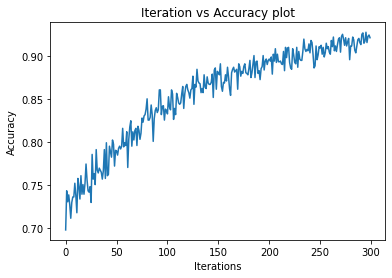

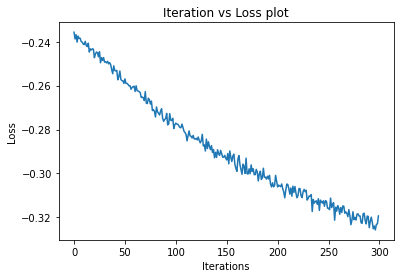

In [34]:
# plotting accuracy and loss
import matplotlib.pyplot as plt

plt.plot(acc_list)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Iteration vs Accuracy plot")
plt.show()

plt.plot(loss_list)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Iteration vs Loss plot")
plt.show()

### Documentation

I've documented the training time,loss and accuracy over iteration for all the algorithms and compared it against each other and against MAML. All the values mentioned below are noted from my personal PC with configuration Intel i5-7th Generation CPU.

#### Matching Network
Total time taken by matching network to get trained is around 261.78 seconds(for 300 iterations). Interestingly the time taken for first 100 iteration is larger than subsequent iterations. The training accuracy started from nearly 70% and went up till 92% within 300 iterations of training. In the first 100 iterations, it touched 84% mark and the subsequent improvements required larger iterations. This might be because of the oscillation around the local minima. The testing accuracy is equally good and around 90%. Plots below have summerized the entire idea.

| Iterations      | Time Taken  |
| -----------     | ----------- |
| 100             | 100.1 s     |
| 200             | 82.8 s      |
| 300             | 78.9 s      |

![ Iteration vs Loss](./plots/man_loss.png "Iteration vs Loss Plot")
![ Iteration vs Accuracy](./plots/man_acc.png "Iteration vs Accuracy Plot")

#### CNP
Total time taken by CNP to get trained is only 88.7 seconds(for 600 iterations). Although the iterations are more, time taken to complete training is much smaller. Here also the time taken for first 100 iteration is larger than subsequent iterations. The training accuracy started from nearly 50% and went up till 93% within 600 iterations of training. The improvement in the accuracy was uniform, unlike MAN. The testing accuracy is also good and around 92.6%. Plots below have summerized the entire idea.

| Iterations      | Time Taken  |
| -----------     | ----------- |
| 100             | 28.9 s      |
| 200             | 11.8 s      |
| 300             | 11.9 s      |
| 400             | 11.8 s      |
| 500             | 12.7 s      |
| 600             | 11.7 s      |

![ Iteration vs Loss](./plots/cnp_loss.png "Iteration vs Loss Plot")
![ Iteration vs Accuracy](./plots/cnp_acc.png "Iteration vs Accuracy Plot")

#### MAML
Total time taken by matching network to get trained is around 224.9 seconds(for 700 iterations). The training accuracy started from very low, nearly 20% and went up till 87% within 700 iterations of training. The increase of the accuracy was slow at the beginning and then increased suddenly and then got saturated. The testing accuracy is equally good and around 85.4%. Plots below have summerized the entire idea.

![ Iteration vs Loss](./plots/maml_loss.png "Iteration vs Loss Plot")
![ Iteration vs Accuracy](./plots/maml_acc.png "Iteration vs Accuracy Plot")

#### Comparision of MAN(Matching Network) and CNP(Conditional Neural Processing) and MAML

| Comparision Parameter     |    MAN    |    CNP    |    MAML    |
| -----------               | --------- | --------- | ---------- |
| Training Time             | 261.78 s  | 88.7 s    | 241.9 s    |
| Train Accuracy            | 92.16     | 93.20     | 87.4       |
| Accuracy started around   | 70.00     | 50.00     | 20         |
| Test Accuracy             | 90.00     | 92.60     | 85.4       |
| Epochs Taken              | 300       | 600       | 700        |

* Training time of CNP is much lower than the rest two(time to saturate).
* Top train accuracy achieved by MAN and CNP is similar, but MAML is a bit lower.
* Interestingly, starting point of three network differs by huge margin. Among them, CNP is giving an initial accuracy of 70%(highest). This depicts, CNP is capable of learning faster then the rest two. MAML starts at a very low accuracy point and climbs up till 87%. MAN started from midpint, 50%.
* Test accuracy of CNP is higher than both MAML and MAN
* Epochs needed to fully train is lowest in MAN, then CNP then MAML. But time taken per epochs is higher in MAN which diminishes this advantage.
* CNP has more fluctuations in accuracy as well as loss while training(refer graph)

#### Overlapping Analysis

##### MAN
**1 overlapping class:** \
With 1 overlapping class, the training accuracy touched 92% in the first 100 epochs and then 95% in the second 100 epochs. Time taken to complete these epochs is also a bit less than the non-overlapping case. But, unfortunately, the test accuracy is around 80% and it remain as it is after training the network for another 100 epochs. This is clearly the case of overfitting.

**2 overlapping class:** \
With 2 overlapping class, it's more or less same, the accuracy jumped from 77% to 90% in first 100 epochs then to 94 in the next 100. Time taken to complete these epochs is similar to non-overlapping case. But, unfortunately, the test accuracy is around 80% and it remain as it is after training the network for another 100 epochs. Overfitting is happening.

**3 overlapping class:** \
Initial results were same as 2 overlappings. But, the time taken to train is significantly higher(2x). It touched the training accuracy of 96% after 200 epochs but testing accuracy was around 79% after first 100 iterations but dropped to 74% after 200 epochs.

With increase in number of overlappings, training accuracy is increasing or staying the same. But the testing accuracy is dropping gradually.

##### MAN
**1 overlapping class:** \
With 1 overlapping, it started with 50% accuracy with almost no moment for first 100 epochs. Then 74% -> 85% and 95% in just 300 to 400 epochs(compared to 600 epochs in non-overlapping case). The test accuracy dropped to 77.2%, which is bad. The training time is also a bit more.

**2 overlapping class:** \
It touched 89% training accuracy with 350 epochs and training accuracy is worse among 3 73%.

**3 overlapping class:** \
With 3 overlappings, training accuracy reached 91%% with 300 epochs(compared to 400 with 1 overlapping). Also, the test accuracy is 80%, which is a bit better than the 1 overlapping case.

With increase in overlappings, the training accuracy randomly fluctuated but the the testing accuracy dropped. With 3, it's coming around 80% which is the highest.